In [17]:
pip install piq

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


In [18]:
pip install scikit-image matplotlib numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


In [19]:
pip install scikit-image matplotlib numpy opencv-python

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


In [20]:
pip install PyWavelets

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


C:\Users\ASUS\AppData\Local\Temp\ipykernel_11912\2877108813.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(generator_path, map_location=device)

Generator model loaded successfully.


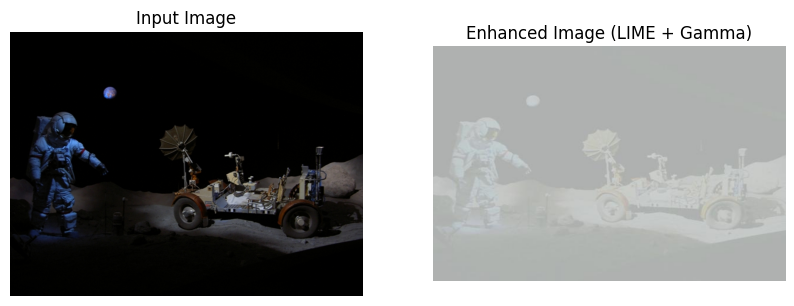

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2

# 1. Environment Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Paths and Configuration
dataset_path = r"C:\\Users\\ASUS\\Downloads\\Mini Dataset"
testA_path = os.path.join(dataset_path, 'testA')
output_folder = os.path.join(dataset_path, 'output')
os.makedirs(output_folder, exist_ok=True)

valid_extensions = ['.png', '.jpg', '.jpeg']

# 3. Define EnlightenGAN Generator Model
class EnlightenGAN_Generator(nn.Module):
    def __init__(self):
        super(EnlightenGAN_Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

generator = EnlightenGAN_Generator().to(device)
generator_path = os.path.join(dataset_path, '200_net_G_A (1).pth')
state_dict = torch.load(generator_path, map_location=device)
generator.load_state_dict(state_dict, strict=False)
generator.eval()
print("Generator model loaded successfully.")

# 4. Helper Functions
def denormalize(tensor):
    return tensor * 0.5 + 0.5

def adaptive_gamma_correction(tensor, gamma=1.5):
    img = (tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    mean_val = np.mean(img)
    adjusted_gamma = 1.2 if mean_val > 150 else 2.0 if mean_val < 70 else gamma
    img = np.power(img / 255.0, 1 / adjusted_gamma)
    return torch.tensor(img).permute(2, 0, 1)

def apply_lime(tensor):
    img = (tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    illumination = cv2.GaussianBlur(img_gray, (9, 9), 10)
    illumination = np.clip(illumination, 30, 200)
    enhanced_img = (img / np.expand_dims(illumination, axis=2)) * 255
    enhanced_img = np.clip(enhanced_img, 0, 255).astype(np.uint8)
    return torch.tensor(enhanced_img / 255.0).permute(2, 0, 1)

def blend_strong_enhancement(original, enhanced, alpha=0.7):
    gamma_corrected = adaptive_gamma_correction(original, gamma=1.6)
    lime_output = apply_lime(original)
    return alpha * enhanced + (1 - alpha) * (0.5 * gamma_corrected + 0.5 * lime_output)

def save_image_with_fixed_size(tensor, save_path):
    tensor = denormalize(tensor).permute(1, 2, 0).numpy()
    image = Image.fromarray((tensor * 255).astype(np.uint8))
    image = image.resize((600, 400), Image.BILINEAR)  # Resize to 600x400
    image.save(save_path)

# 5. Image Processing Function
def process_images_strong(folder_path):
    enhanced_images = []

    for root, _, files in os.walk(folder_path):
        for img_name in files:
            if not any(img_name.lower().endswith(ext) for ext in valid_extensions):
                continue

            img_path = os.path.join(root, img_name)
            image = Image.open(img_path).convert("RGB")
            input_tensor = transform(image).unsqueeze(0).to(device)

            with torch.no_grad():
                enhanced = generator(input_tensor)

            enhanced = denormalize(enhanced.squeeze(0).cpu())
            original = denormalize(input_tensor.squeeze(0).cpu())
            final_output = blend_strong_enhancement(original, enhanced, alpha=0.75)

            relative_path = os.path.relpath(img_path, testA_path)
            save_path = os.path.join(output_folder, relative_path)
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            save_image_with_fixed_size(final_output, save_path)

            enhanced_images.append((img_path, save_path))

    if enhanced_images:
        random_input, random_output = random.choice(enhanced_images)
        input_image = Image.open(random_input)
        output_image = Image.open(random_output)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        plt.imshow(input_image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Enhanced Image (LIME + Gamma)")
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()

# 6. Preprocessing Pipeline
transform = transforms.Compose([
    transforms.Resize((400, 600)),  # Resize to 600x400 (Height x Width)
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 7. Execute the Model
process_images_strong(testA_path)

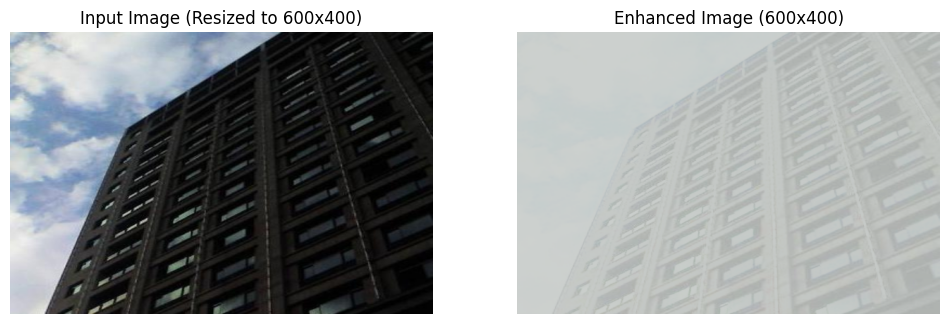

In [2]:
import matplotlib.pyplot as plt
import random
from PIL import Image

def view_random_output(folder_path, output_folder):
    # Collect all processed image paths
    enhanced_images = []
    for root, _, files in os.walk(folder_path):
        for img_name in files:
            if not any(img_name.lower().endswith(ext) for ext in valid_extensions):
                continue
            input_path = os.path.join(root, img_name)
            relative_path = os.path.relpath(input_path, testA_path)
            output_path = os.path.join(output_folder, relative_path)
            if os.path.exists(output_path):
                enhanced_images.append((input_path, output_path))

    if not enhanced_images:
        print("No enhanced images found. Make sure the processing function has been run.")
        return

    # Pick a random image for visualization
    random_input, random_output = random.choice(enhanced_images)
    input_image = Image.open(random_input).resize((600, 400), Image.BILINEAR)
    output_image = Image.open(random_output).resize((600, 400), Image.BILINEAR)

    # Display input and output images side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Input Image (Resized to 600x400)")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Enhanced Image (600x400)")
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()

# Call the function to view a random image
view_random_output(testA_path, output_folder)

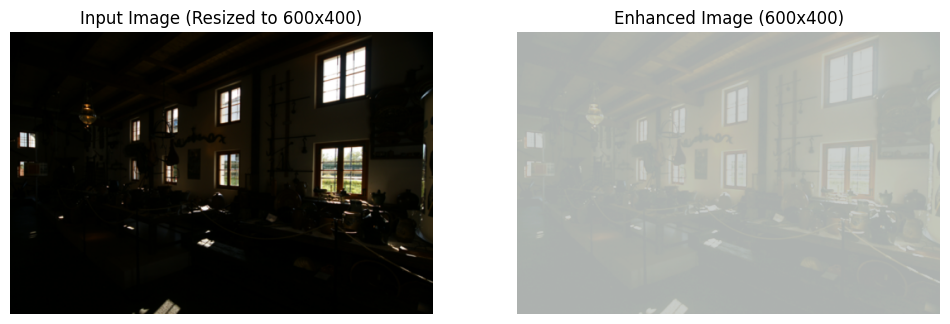

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def view_specific_output(input_image_path, output_base_path):
    # Calculate the relative path of the input image
    relative_path = os.path.relpath(input_image_path, testA_path)
    output_image_path = os.path.join(output_base_path, relative_path)

    # Check if the output image exists
    if not os.path.exists(output_image_path):
        print(f"Enhanced image not found at: {output_image_path}")
        return

    # Load and resize the input and output images
    input_image = Image.open(input_image_path).resize((600, 400), Image.BILINEAR)
    output_image = Image.open(output_image_path).resize((600, 400), Image.BILINEAR)

    # Display input and output images side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Input Image (Resized to 600x400)")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Enhanced Image (600x400)")
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\Mini Dataset\testA\data\MEF\Farmhouse.png"
view_specific_output(input_image_path, output_folder)

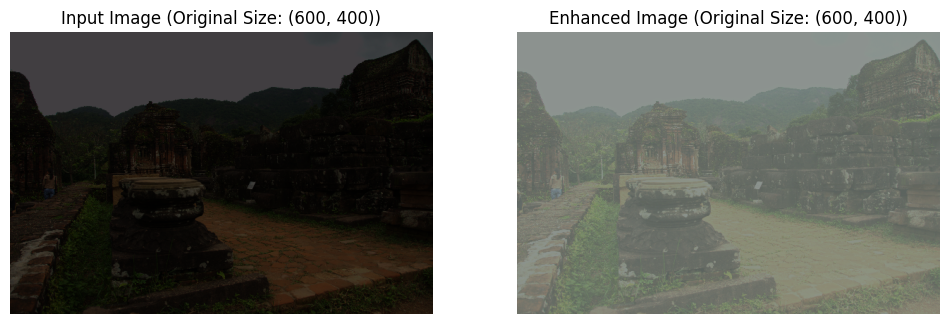

Enhanced image saved at: C:\Users\ASUS\Downloads\test\output\low10404.png


In [4]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

def process_single_image_dynamic(input_image_path):
    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced = denormalize(enhanced.squeeze(0).cpu())
    original = denormalize(input_tensor.squeeze(0).cpu())
    final_output = blend_strong_enhancement(original, enhanced, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Display the input and enhanced images side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")

# Preprocessing pipeline for the input image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\test\low10404.png"
process_single_image_dynamic(input_image_path)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_11912\2888435837.py:43: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


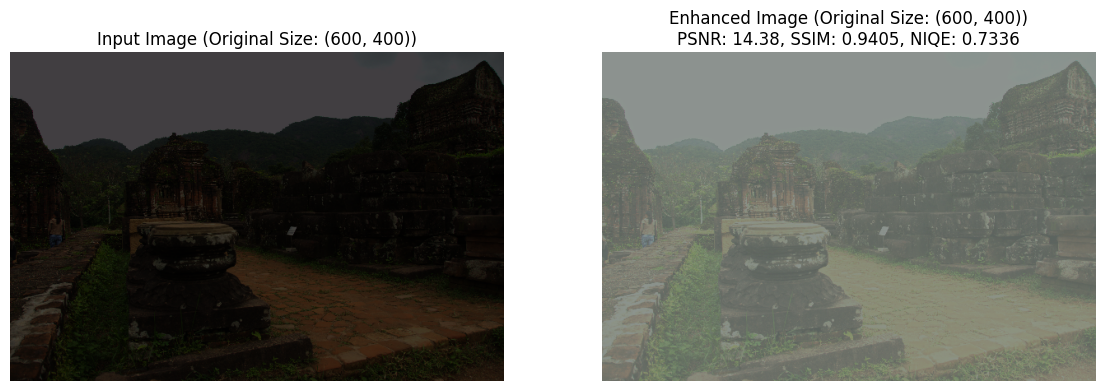

Enhanced image saved at: C:\Users\ASUS\Downloads\test\output\low10404.png
PSNR: 14.38, SSIM: 0.9405, NIQE: 0.7336


In [5]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\test\low10404.png"
process_single_image_with_metrics(input_image_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11912\2529699030.py:43: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


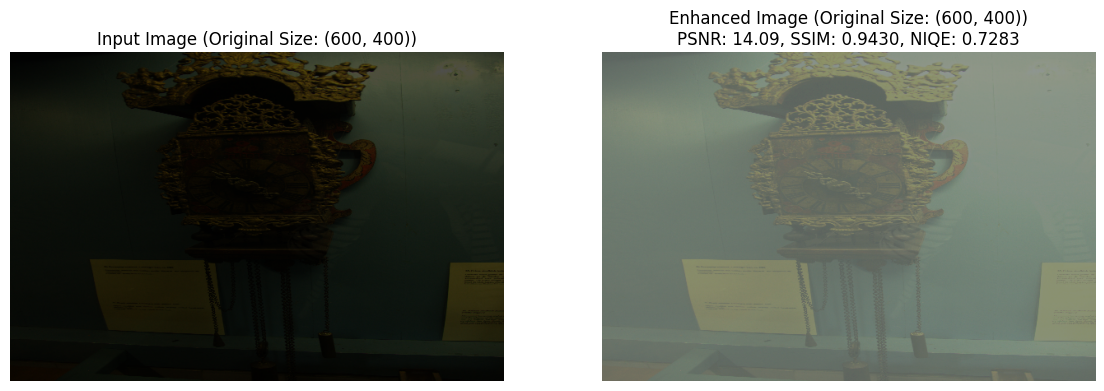

Enhanced image saved at: C:\Users\ASUS\Downloads\test\output\low10417.png
PSNR: 14.09, SSIM: 0.9430, NIQE: 0.7283


In [6]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\test\low10417.png"
process_single_image_with_metrics(input_image_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11912\204572810.py:45: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


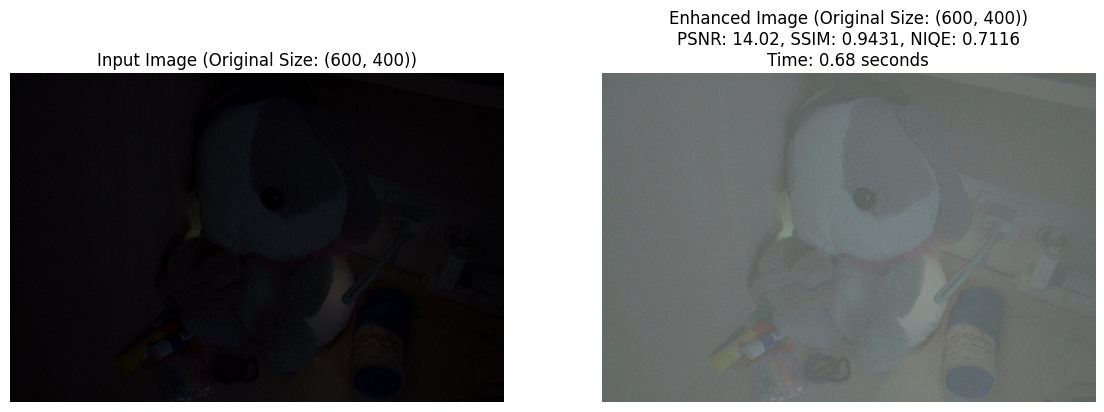

Enhanced image saved at: C:\Users\ASUS\Downloads\Mini Dataset\trainA\output\low00554.png
PSNR: 14.02, SSIM: 0.9431, NIQE: 0.7116
Processing Time: 0.68 seconds


In [7]:
import time  # Importing the time module to measure execution time

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    start_time = time.time()  # Start measuring time

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\Mini Dataset\trainA\low00554.png"
process_single_image_with_metrics(input_image_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11912\3773476933.py:46: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


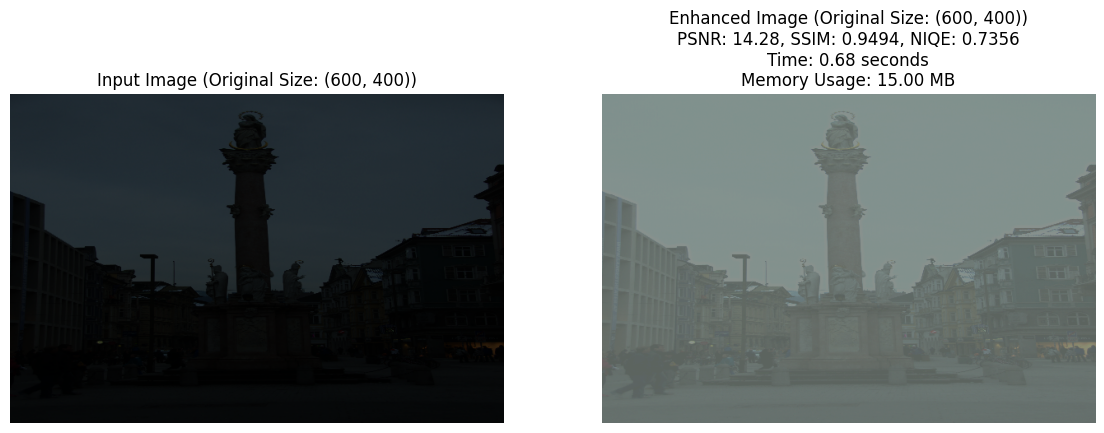

Enhanced image saved at: C:\Users\ASUS\Downloads\Mini Dataset\trainA\output\low10910.png
PSNR: 14.28, SSIM: 0.9494, NIQE: 0.7356
Processing Time: 0.68 seconds
Memory Usage: 15.00 MB


In [8]:
import time  # For time measurement
import psutil  # For memory usage monitoring

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    start_time = time.time()  # Start measuring time
    process = psutil.Process()  # Initialize memory tracking
    start_memory = process.memory_info().rss / (1024 * 1024)  # Memory in MB

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time and memory
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    end_memory = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    memory_usage = end_memory - start_memory  # Memory consumed during processing

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds\nMemory Usage: {memory_usage:.2f} MB")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")
    print(f"Memory Usage: {memory_usage:.2f} MB")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\Mini Dataset\trainA\low10910.png"
process_single_image_with_metrics(input_image_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11912\1031834304.py:46: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


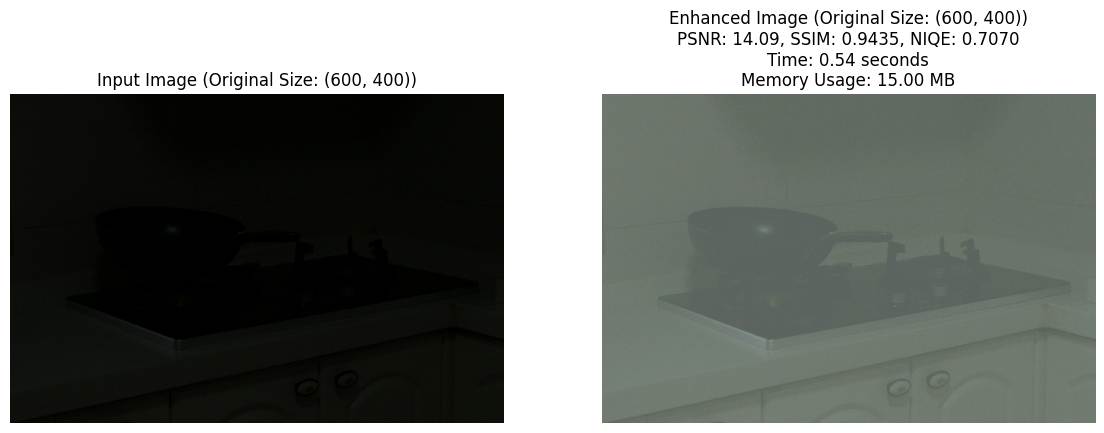

Enhanced image saved at: C:\Users\ASUS\Downloads\Mini Dataset\trainA\output\low00094.png
PSNR: 14.09, SSIM: 0.9435, NIQE: 0.7070
Processing Time: 0.54 seconds
Memory Usage: 15.00 MB


In [9]:
import time  # For time measurement
import psutil  # For memory usage monitoring

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    start_time = time.time()  # Start measuring time
    process = psutil.Process()  # Initialize memory tracking
    start_memory = process.memory_info().rss / (1024 * 1024)  # Memory in MB

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time and memory
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    end_memory = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    memory_usage = end_memory - start_memory  # Memory consumed during processing

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds\nMemory Usage: {memory_usage:.2f} MB")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")
    print(f"Memory Usage: {memory_usage:.2f} MB")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\Mini Dataset\trainA\low00094.png"
process_single_image_with_metrics(input_image_path)

In [10]:
import time  # For time measurement
import psutil  # For memory usage monitoring

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    start_time = time.time()  # Start measuring time
    process = psutil.Process()  # Initialize memory tracking
    start_memory = process.memory_info().rss / (1024 * 1024)  # Memory in MB

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time and memory
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    end_memory = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    memory_usage = end_memory - start_memory  # Memory consumed during processing

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds\nMemory Usage: {memory_usage:.2f} MB")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")
    print(f"Memory Usage: {memory_usage:.2f} MB")

# Example usage: Specify the input image path
input_image_path = r"D:\Photos\021A0125.JPG"
process_single_image_with_metrics(input_image_path)

Input image not found at: D:\Photos\021A0125.JPG


In [11]:
import time  # For time measurement
import psutil  # For memory usage monitoring

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

# List of valid image extensions
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']

def is_valid_image(file_path):
    """Check if the file has a valid image extension."""
    _, ext = os.path.splitext(file_path)
    return ext.lower() in valid_extensions

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    # Validate the input format
    if not is_valid_image(input_image_path):
        print(f"Invalid input format. Input must be one of the following formats: {', '.join(valid_extensions)}")
        return

    start_time = time.time()  # Start measuring time
    process = psutil.Process()  # Initialize memory tracking
    start_memory = process.memory_info().rss / (1024 * 1024)  # Memory in MB

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time and memory
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    end_memory = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    memory_usage = end_memory - start_memory  # Memory consumed during processing

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds\nMemory: {memory_usage:.2f} MB")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")
    print(f"Memory Usage: {memory_usage:.2f} MB")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\input.txt"
process_single_image_with_metrics(input_image_path)

Invalid input format. Input must be one of the following formats: .jpg, .jpeg, .png, .bmp, .tiff


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24036\4285036191.py:45: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


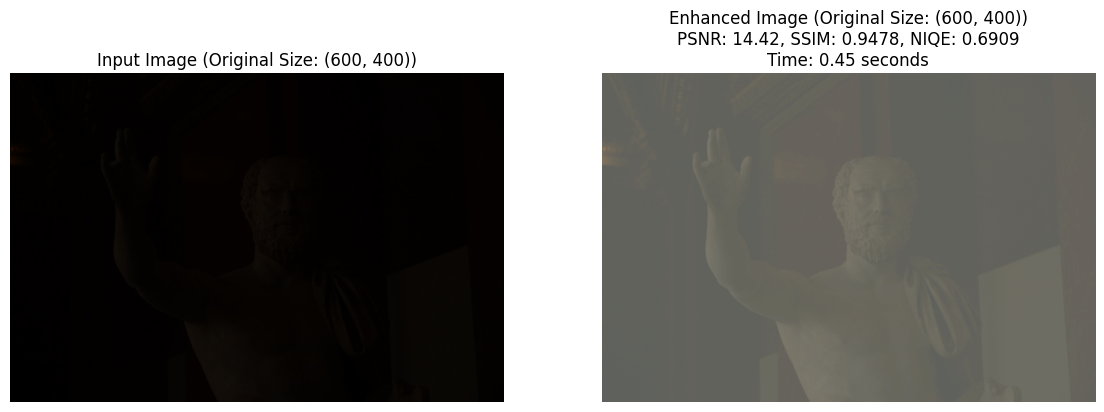

Enhanced image saved at: C:\Users\ASUS\Downloads\test\output\low10409.png
PSNR: 14.42, SSIM: 0.9478, NIQE: 0.6909
Processing Time: 0.45 seconds


In [32]:
import time  # Importing the time module to measure execution time

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    start_time = time.time()  # Start measuring time

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\test\low10409.png"
process_single_image_with_metrics(input_image_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24036\2897164149.py:57: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


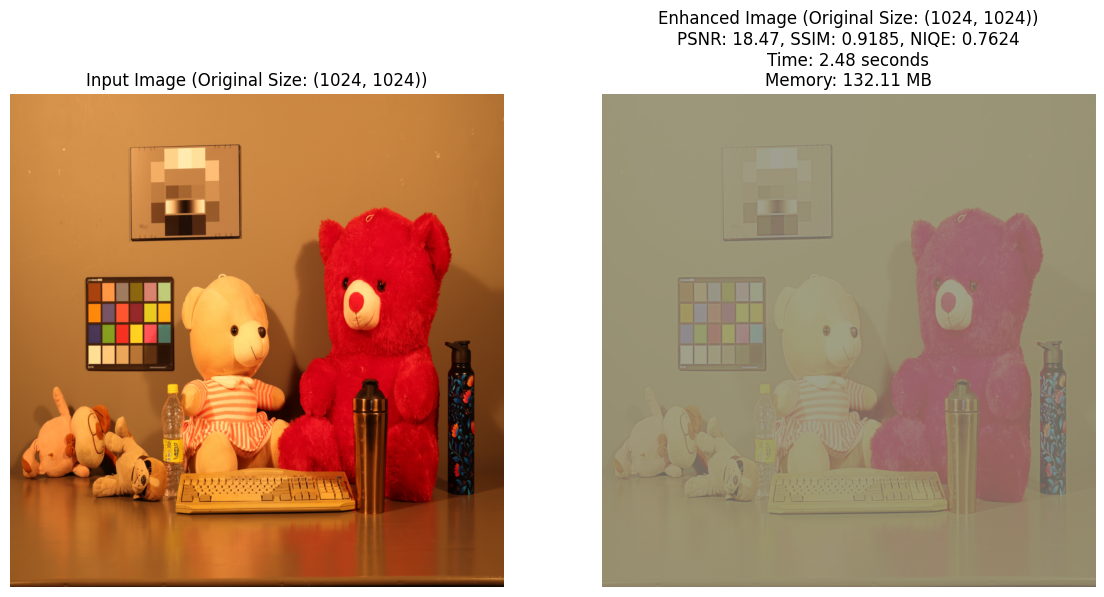

Enhanced image saved at: C:\Users\ASUS\Downloads\output\021A0155.JPG
PSNR: 18.47, SSIM: 0.9185, NIQE: 0.7624
Processing Time: 2.48 seconds
Memory Usage: 132.11 MB


In [36]:
import matplotlib.pyplot as plt
import time  # For time measurement
import psutil  # For memory usage monitoring
from PIL import Image
import torch

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

# List of valid image extensions
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']

def is_valid_image(file_path):
    """Check if the file has a valid image extension."""
    _, ext = os.path.splitext(file_path)
    return ext.lower() in valid_extensions

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    start_time = time.time()  # Start measuring time
    process = psutil.Process()  # Initialize memory tracking
    start_memory = process.memory_info().rss / (1024 * 1024)  # Memory in MB

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Validate input format
    if not is_valid_image(input_image_path):
        print(f"Invalid input format. Input must be one of the following formats: {', '.join(valid_extensions)}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and resize it to reduce memory usage
    input_image = Image.open(input_image_path).convert("RGB")
    input_image = input_image.resize((1024, 1024), Image.BILINEAR)  # Resize to 1024x1024
    original_size = input_image.size  # Save original size for restoring later

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Restore original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time and memory
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    end_memory = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    memory_usage = end_memory - start_memory  # Memory consumed during processing

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds\nMemory: {memory_usage:.2f} MB")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")
    print(f"Memory Usage: {memory_usage:.2f} MB")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\021A0155.JPG"
process_single_image_with_metrics(input_image_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11912\985176050.py:45: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


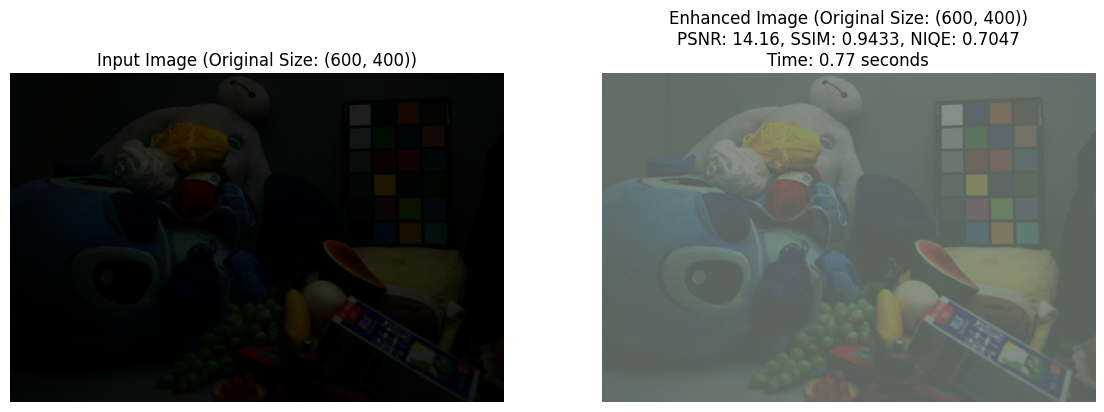

Enhanced image saved at: C:\Users\ASUS\Downloads\Mini Dataset\trainA\output\low00519.png
PSNR: 14.16, SSIM: 0.9433, NIQE: 0.7047
Processing Time: 0.77 seconds


In [15]:
import time  # Importing the time module to measure execution time

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    start_time = time.time()  # Start measuring time

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\Mini Dataset\trainA\low00519.png"
process_single_image_with_metrics(input_image_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11912\2392483570.py:45: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


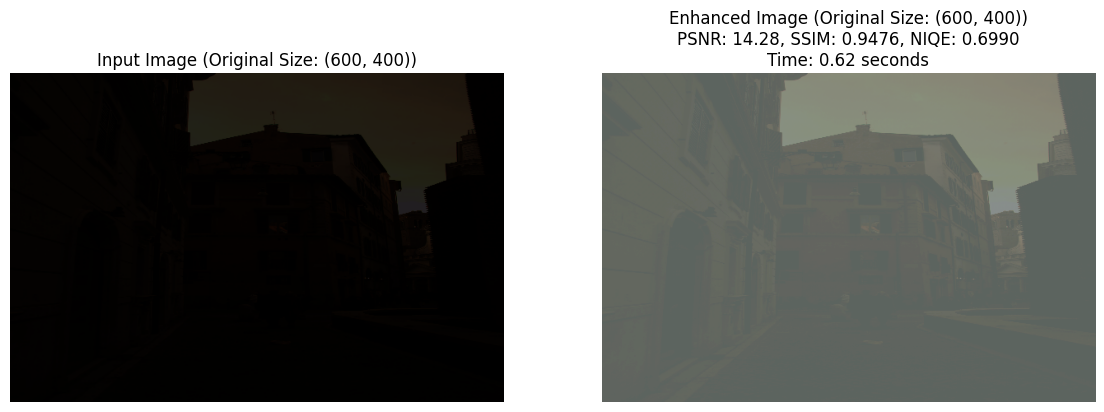

Enhanced image saved at: C:\Users\ASUS\Downloads\Mini Dataset\trainA\output\low10915.png
PSNR: 14.28, SSIM: 0.9476, NIQE: 0.6990
Processing Time: 0.62 seconds


In [16]:
import time  # Importing the time module to measure execution time

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    start_time = time.time()  # Start measuring time

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\Mini Dataset\trainA\low10915.png"
process_single_image_with_metrics(input_image_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11912\3056076854.py:45: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


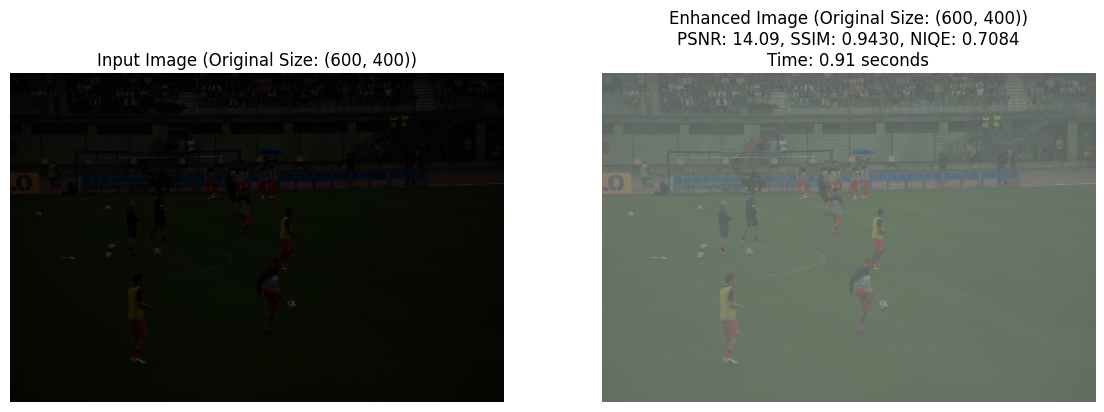

Enhanced image saved at: C:\Users\ASUS\Downloads\Mini Dataset\trainA\output\low10722.png
PSNR: 14.09, SSIM: 0.9430, NIQE: 0.7084
Processing Time: 0.91 seconds


In [17]:
import time  # Importing the time module to measure execution time

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    start_time = time.time()  # Start measuring time

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\Mini Dataset\trainA\low10722.png"
process_single_image_with_metrics(input_image_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11912\1175943971.py:45: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


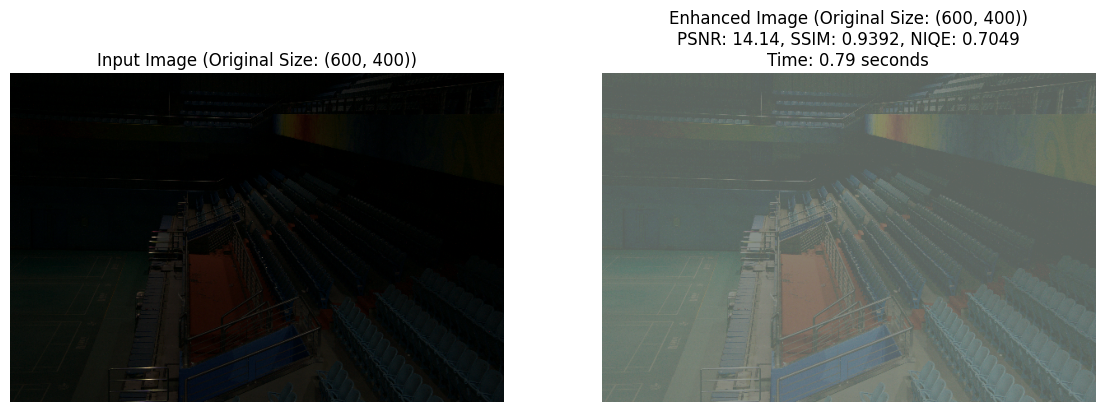

Enhanced image saved at: C:\Users\ASUS\Downloads\Mini Dataset\trainA\output\low00778.png
PSNR: 14.14, SSIM: 0.9392, NIQE: 0.7049
Processing Time: 0.79 seconds


In [18]:
import time  # Importing the time module to measure execution time

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    start_time = time.time()  # Start measuring time

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\Mini Dataset\trainA\low00778.png"
process_single_image_with_metrics(input_image_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11912\2676037366.py:45: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


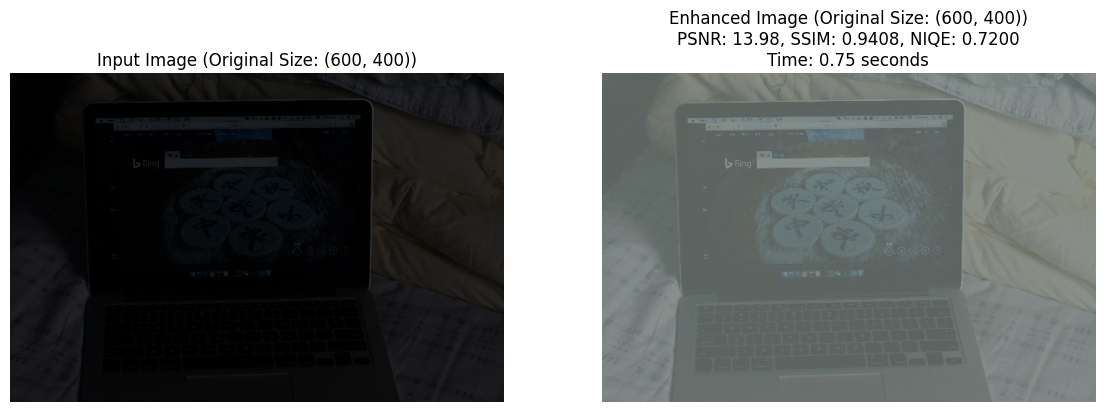

Enhanced image saved at: C:\Users\ASUS\Downloads\Mini Dataset\trainA\output\low00264.png
PSNR: 13.98, SSIM: 0.9408, NIQE: 0.7200
Processing Time: 0.75 seconds


In [20]:
import time  # Importing the time module to measure execution time

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    start_time = time.time()  # Start measuring time

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\Mini Dataset\trainA\low00264.png"
process_single_image_with_metrics(input_image_path)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11912\931740709.py:45: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument


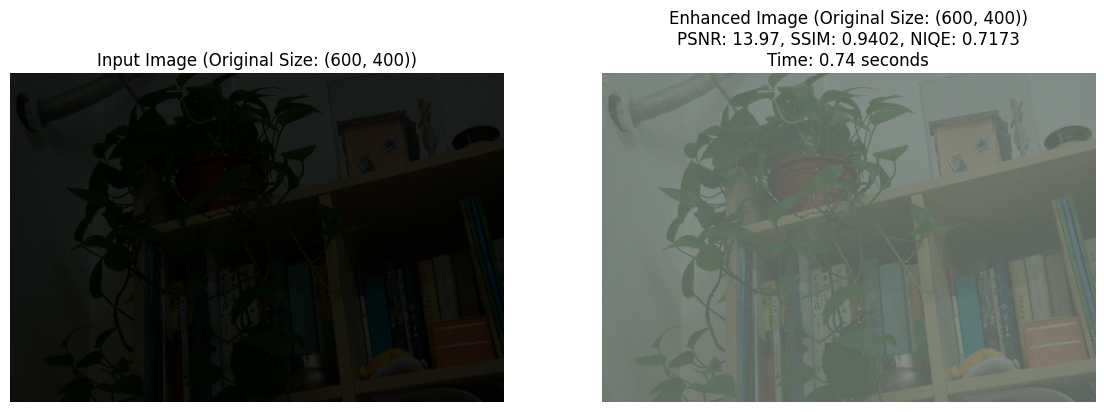

Enhanced image saved at: C:\Users\ASUS\Downloads\Mini Dataset\trainA\output\low00538.png
PSNR: 13.97, SSIM: 0.9402, NIQE: 0.7173
Processing Time: 0.74 seconds


In [21]:
import time  # Importing the time module to measure execution time

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage import img_as_float
from skimage.filters import gaussian
import numpy as np
import cv2

def compute_metrics(original_tensor, enhanced_tensor):
    # Convert tensors to numpy arrays
    original = (denormalize(original_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")
    enhanced = (denormalize(enhanced_tensor).permute(1, 2, 0).numpy() * 255).astype("uint8")

    # Resize images if either dimension is smaller than 7
    min_dimension = min(original.shape[:2])
    if min_dimension < 7:
        resize_factor = 7 / min_dimension
        original = cv2.resize(original, (int(original.shape[1] * resize_factor), int(original.shape[0] * resize_factor)))
        enhanced = cv2.resize(enhanced, (int(enhanced.shape[1] * resize_factor), int(enhanced.shape[0] * resize_factor)))

    # PSNR
    psnr_value = psnr(original, enhanced, data_range=255)

    # SSIM: Pass `win_size` explicitly if images are small
    win_size = min(7, min(original.shape[:2]))
    ssim_value = ssim(original, enhanced, data_range=255, channel_axis=-1, win_size=win_size)

    # NIQE approximation using Gaussian Blurring
    niqe_value = compute_niqe_approximation(enhanced)

    return psnr_value, ssim_value, niqe_value

def compute_niqe_approximation(image):
    """
    Approximates NIQE using Gaussian Blurring and noise estimation.
    """
    # Convert image to floating point
    image_float = img_as_float(image)

    # Apply Gaussian Blur
    blurred_image = gaussian(image_float, sigma=1)

    # Estimate noise
    noise_std = estimate_sigma(image_float)  # Removed `multichannel` argument

    # Calculate NIQE approximation (lower is better)
    niqe_value = np.mean(np.abs(blurred_image - noise_std))
    return niqe_value

# Main Image Processing with Metrics
def process_single_image_with_metrics(input_image_path):
    start_time = time.time()  # Start measuring time

    # Ensure the input image exists
    if not os.path.exists(input_image_path):
        print(f"Input image not found at: {input_image_path}")
        return

    # Define the output directory relative to the input image path
    input_dir = os.path.dirname(input_image_path)
    output_dir = os.path.join(input_dir, "output")
    os.makedirs(output_dir, exist_ok=True)

    # Define the output image path
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path))

    # Load the input image and get its original size
    input_image = Image.open(input_image_path).convert("RGB")
    original_size = input_image.size  # (width, height)

    # Transform the input image into a tensor
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    # Enhance the image using the generator
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)

    # Post-process the enhanced tensor
    enhanced_tensor = denormalize(enhanced_tensor.squeeze(0).cpu())
    original_tensor = denormalize(input_tensor.squeeze(0).cpu())
    final_output_tensor = blend_strong_enhancement(original_tensor, enhanced_tensor, alpha=0.75)

    # Save the enhanced image with the original size
    final_output_image = Image.fromarray((final_output_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))
    final_output_image = final_output_image.resize(original_size, Image.BILINEAR)  # Resize to original size
    final_output_image.save(output_image_path)

    # Compute metrics
    psnr_value, ssim_value, niqe_value = compute_metrics(original_tensor, final_output_tensor)

    # Stop measuring time
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time

    # Display the input and enhanced images side by side with metrics
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Input Image (Original Size: {original_size})")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Enhanced Image (Original Size: {original_size})\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}\nTime: {elapsed_time:.2f} seconds")
    plt.imshow(final_output_image)
    plt.axis('off')
    plt.show()

    print(f"Enhanced image saved at: {output_image_path}")
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, NIQE: {niqe_value:.4f}")
    print(f"Processing Time: {elapsed_time:.2f} seconds")

# Example usage: Specify the input image path
input_image_path = r"C:\Users\ASUS\Downloads\Mini Dataset\trainA\low00538.png"
process_single_image_with_metrics(input_image_path)